<a href="https://colab.research.google.com/github/HD666g/NTHU_2023_DLBOI_HW/blob/main/HW3/hw3_report_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# National Tsing Hua University

#### Fall 2023

##### 11210IPT 553000

##### Deep Learning in Biomedical Optical Imaging

## HW3 Report

### studnet id:112066513

</div>


# 1. Download Datasets

In [ ]:
# Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

--2023-10-26 17:07:12--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   223MB/s    in 0.3s    

2023-10-26 17:07:13 (223 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-10-26 17:07:13--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

# 2. Create training dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train0 = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val0 = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train0).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val0).float().unsqueeze(1)
y_val = torch.from_numpy(y_val).long()

x_train_un = torch.from_numpy(x_train0).float()
x_val_un = torch.from_numpy(x_val0).float()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


# 3. Setup the model for Task A and B



The x_train & x_val tensors are for CNN \
The x_train_un & x_val_un are for ANN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 32), # 1st FC
#     nn.ReLU(),
#     nn.Linear(32, 32),        # 2nd FC
#     nn.ReLU(),
#     nn.Linear(32, 32),        # 3rd FC
#     nn.ReLU(),
#     nn.Linear(32, 1)          # 4th FC
# ).cuda()

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256*256*1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 1 channel, and using 3x3 kernels for simplicity, 256*256
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128*128

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 128*128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64*64

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32*32

        # Adjust flattened dimensions based on the output size of your last pooling layer
        flattened_dim = 32 * 32 * 32

        self.fc1 = nn.Linear(flattened_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # x.size(0) is the batch size

        x = F.relu(self.fc1(x))
        return self.fc2(x)

## 3. Setup test dataset

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).float().unsqueeze(1)
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, 32, shuffle=False)

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


# Task A: Reduce Overfitting

## Training Part

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
import math

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

# Change you model here
model = ConvModel()
print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.5189, Train acc: 70.56%, Val loss: 0.3076, Val acc: 89.25%, Best Val loss: 0.3076 Best Val acc: 89.25%
Epoch 2/30, Train loss: 0.1441, Train acc: 94.62%, Val loss: 0.1228, Val acc: 95.00%, Best Val loss: 0.1228 Best Val acc: 95.00%
Epoch 3/30, Train loss: 0.1257, Train acc: 95.44%, Val loss: 0.1084, Val acc: 95.50%, Best Val loss: 0.1084 Best Val acc: 95.50%
Epoch 4/30, Train loss: 0.0884, Train acc: 97.12%, Val loss: 0.1114, Val acc: 95.25%, Best Val loss: 0.1084 Best Val acc: 95.50%
Epoch 5/30, Train loss: 0.0769, Train acc: 97.00%, Val loss: 0.0945, Val acc: 96.00%, Best Val loss: 0.0945 Best Val acc: 96.00%
Epoch 6/30, Train loss: 0.0507, Train acc: 98.38%, Val loss: 0.0923, Val acc: 96.75%, Best Val loss: 0.0923 Best Val acc: 96.75%
Epoch 7/30, Train loss: 0.0431, Train acc: 98.62%, Val loss: 0.0917, Val acc: 96.25%, Best Val loss: 0.0917 Best Val acc: 96.75%
Epoch 8/30, Train loss: 0.0418, Train acc: 98.56%, Val loss: 0.0979, Val acc: 95.75%, Best Val lo

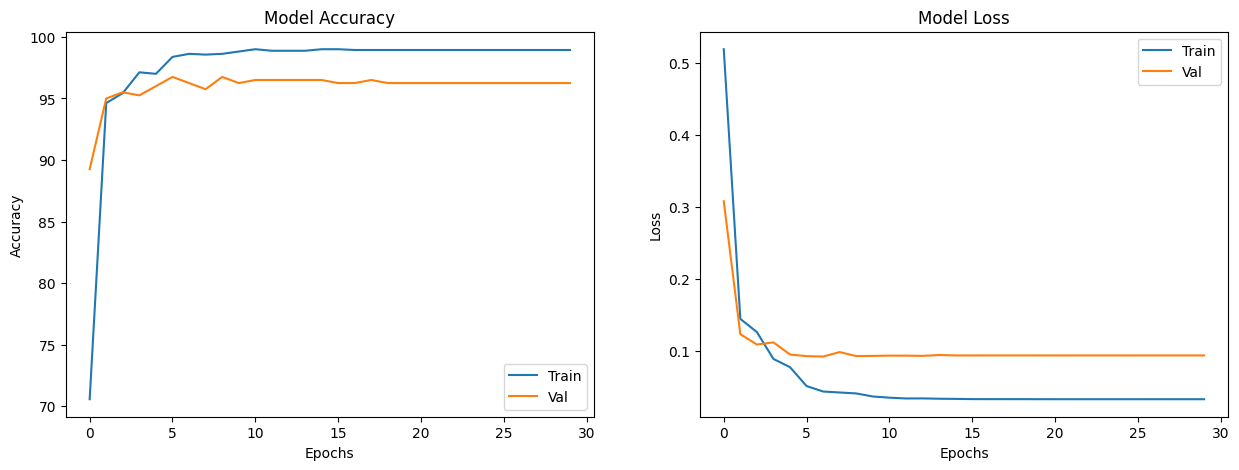

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## Testing Part

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()

        outputs = model(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted = torch.sigmoid(outputs) > 0.5

        test_correct += (predicted.float() == labels_float).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 75.25%


# Task B: Performance Comparison between CNN and ANN

## CNN

### Training Part

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
import math

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

# Change you model here
model = ConvModel()
print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.4600, Train acc: 75.31%, Val loss: 0.2327, Val acc: 90.50%, Best Val loss: 0.2327 Best Val acc: 90.50%
Epoch 2/30, Train loss: 0.2217, Train acc: 92.00%, Val loss: 0.1893, Val acc: 92.50%, Best Val loss: 0.1893 Best Val acc: 92.50%
Epoch 3/30, Train loss: 0.1171, Train acc: 95.56%, Val loss: 0.2020, Val acc: 93.25%, Best Val loss: 0.1893 Best Val acc: 93.25%
Epoch 4/30, Train loss: 0.1130, Train acc: 95.62%, Val loss: 0.1680, Val acc: 93.25%, Best Val loss: 0.1680 Best Val acc: 93.25%
Epoch 5/30, Train loss: 0.1033, Train acc: 95.94%, Val loss: 0.1164, Val acc: 95.00%, Best Val loss: 0.1164 Best Val acc: 95.00%
Epoch 6/30, Train loss: 0.0801, Train acc: 97.19%, Val loss: 0.1105, Val acc: 96.00%, Best Val loss: 0.1105 Best Val acc: 96.00%
Epoch 7/30, Train loss: 0.0506, Train acc: 98.19%, Val loss: 0.1122, Val acc: 96.50%, Best Val loss: 0.1105 Best Val acc: 96.50%
Epoch 8/30, Train loss: 0.0429, Train acc: 98.12%, Val loss: 0.1064, Val acc: 97.25%, Best Val lo

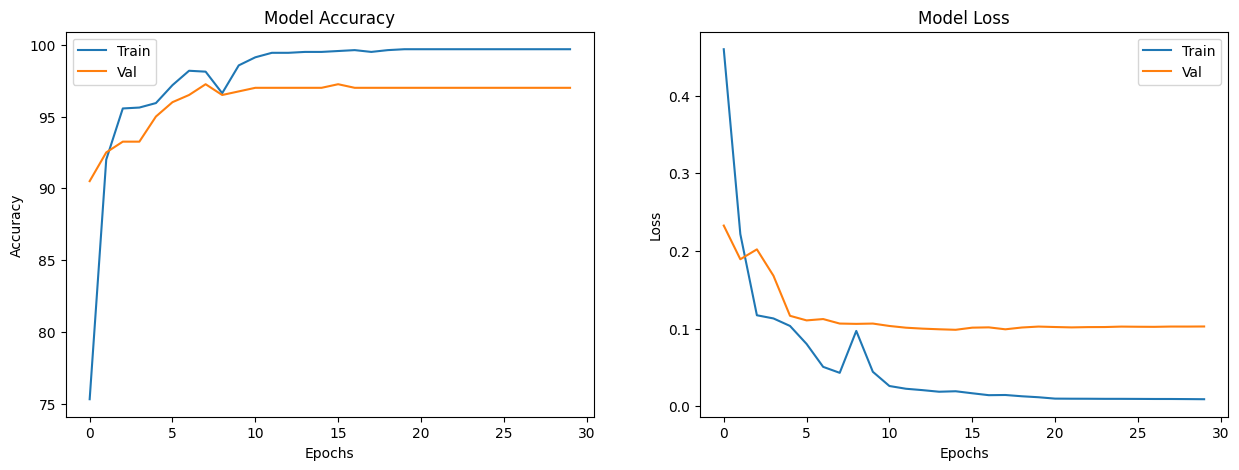

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])
plt.savefig('1BConv_train.png')
plt.show()
files.download('1BConv_train.png')

### Testing Part

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()

        outputs = model(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted = torch.sigmoid(outputs) > 0.5

        test_correct += (predicted.float() == labels_float).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 74.0%


## ANN

### Training Part

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
import math

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

# Change you model here
model = LinearModel()
print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

LinearModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=65536, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.4959, Train acc: 76.25%, Val loss: 0.6547, Val acc: 67.25%, Best Val loss: 0.6547 Best Val acc: 67.25%
Epoch 2/30, Train loss: 0.3299, Train acc: 85.75%, Val loss: 0.2491, Val acc: 90.50%, Best Val loss: 0.2491 Best Val acc: 90.50%
Epoch 3/30, Train loss: 0.2180, Train acc: 91.50%, Val loss: 0.2288, Val acc: 92.25%, Best Val loss: 0.2288 Best Val acc: 92.25%
Epoch 4/30, Train loss: 0.1751, Train acc: 93.44%, Val loss: 0.1868, Val acc: 94.25%, Best Val loss: 0.1868 Best Val acc: 94.25%
Epoch 5/30, Train loss: 0.1674, Train acc: 93.31%, Val loss: 0.1774, Val acc: 93.50%, Best Val loss: 0.1774 Best Val acc: 94.25%
Epoch 6/30, Train loss: 0.1512, Train acc: 94.00%, Val loss: 0.3857, Val acc: 85.75%, Best Val loss: 0.1774 Best Val acc: 94.25%
Epoch 7/30, Train loss: 0.1716, Train acc: 93.25%, Val loss: 0.2692, Val acc: 89.00%, Best Val loss: 0.1774 Best Val acc: 94.25%
Epoch 8/30, Train loss: 0.1725, Train acc: 93.50%, Val loss: 0.2536, Val acc: 92.00%, Best Val lo

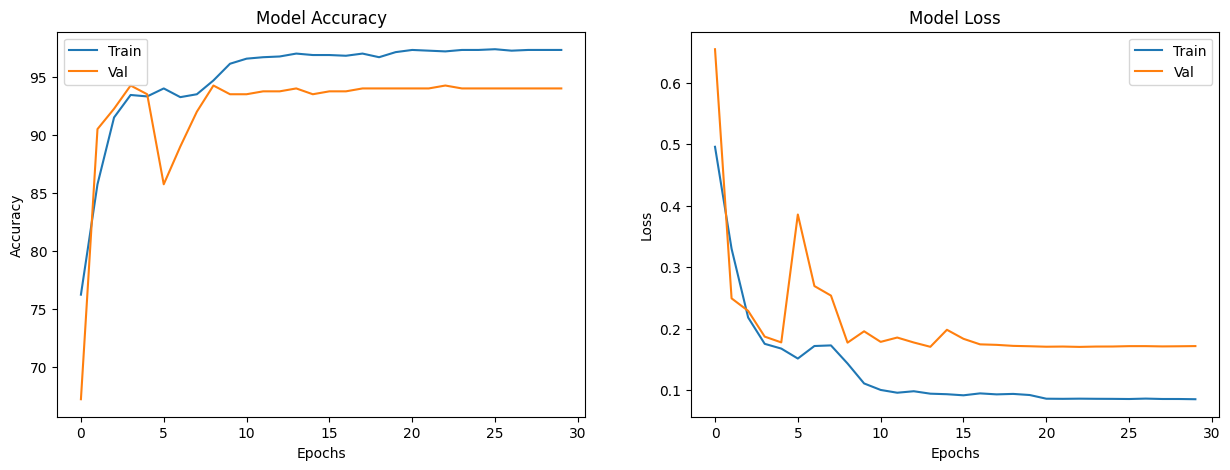

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])
plt.savefig('1BANN_train.png')
plt.show()
files.download('1BANN_train.png')

### Testing Part

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()

        outputs = model(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted = torch.sigmoid(outputs) > 0.5

        test_correct += (predicted.float() == labels_float).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 72.0%


# Task C: Global Average Pooling in CNNs

## Setup GAP model

In [ ]:
class ConvGAP(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same') ,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128*128
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 128*128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*64
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 64*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*32

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1)
        )

    def forward(self, x):

        x = self.net(x)
        return x

## Training Part

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
import math

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

# Change you model here
model = ConvGAP()
print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

ConvGAP(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.6947, Train acc: 50.06%, Val loss: 0.6891, Val acc: 53.75%, Best Val loss: 0.6891 Best Val acc: 53.75%
Epoch 2/30, Train loss: 0.6800, Train acc: 61.38%, Val loss: 0.6520, Val acc: 66.00%, Best Val loss: 0.6520 Best Val acc: 66.00%
Epoch 3/30, Train loss: 0.6592, Train acc: 62.94%, Val loss: 0.6187, Val acc: 73.00%, Best Val loss: 0.6187 Best Val acc: 73.00%
Epoch 4/30, Train loss: 0.6354, Train acc: 66.56%, Val loss: 0.6070, Val acc: 70.00%, Best Val loss: 0.6070 Best Val acc: 73.00%
Epoch 5/30, Train loss: 0.6216, Train acc: 67.94%, Val loss: 0.6009, Val acc: 68.75%, Best Val loss: 0.6009 Best Val acc: 73.00%
Epoch 6/30, Train loss: 0.6016, Train acc: 70.06%, Val loss: 0.5623, Val acc: 73.50%, Best Val loss: 0.5623 Best Val acc: 73.50%
Epoch 7/30, Train loss: 0.5798, Train acc: 72.38%, Val loss: 0.5552, Val acc: 74.25%, Best Val loss: 0.5552 Best Val acc: 74.25%
Epoch 8/30, Train loss: 0.5361, Train acc: 75.38%, Val loss: 0.5149, Val acc: 78.50%, Best Val lo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

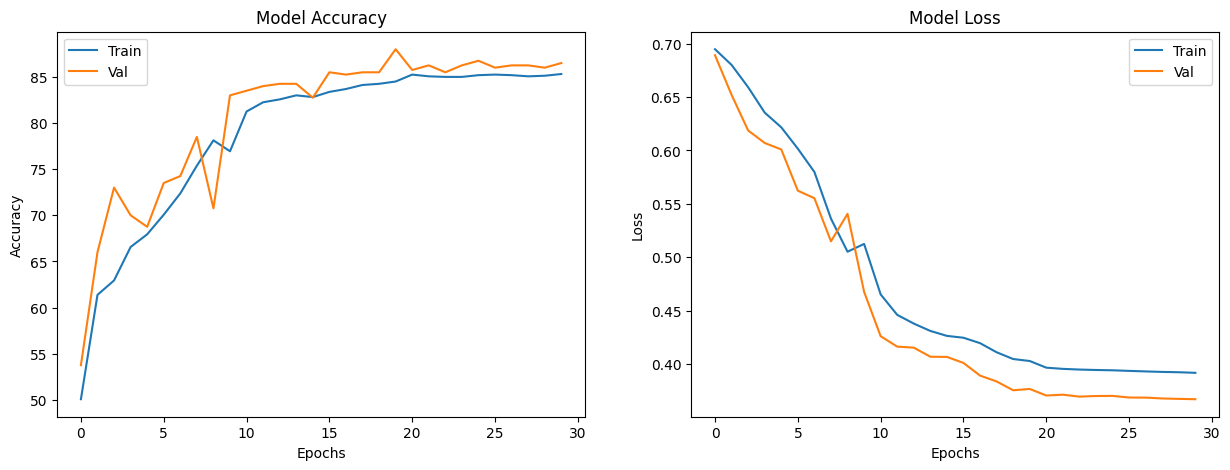

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('1Cst_train.png')
files.download('1Cst_train.png')
plt.show()


## Testing Part

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()

        outputs = model(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted = torch.sigmoid(outputs) > 0.5

        test_correct += (predicted.float() == labels_float).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 71.0%
